In [135]:
!pip show seaborn

Name: seaborn
Version: 0.13.1
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: matplotlib, numpy, pandas
Required-by: missingno


In [111]:
#Importamos paquetes importantes
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#Cargamos el dataset

df1 = pd.read_csv('language_detection.csv')
df2 = pd.read_csv('language_detection2.csv')
df2 = df2.rename(columns = {'Language':'language'})
print(df2.head(5))

print("\n ================================================== \n")


#Revisamos la distribución de texto por idioma
print(df1["language"].value_counts())

                                                Text language
0   Nature, in the broadest sense, is the natural...  English
1  "Nature" can refer to the phenomena of the phy...  English
2  The study of nature is a large, if not the onl...  English
3  Although humans are part of nature, human acti...  English
4  [1] The word nature is borrowed from the Old F...  English


language
Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: count, dtype: int64


In [112]:
#Preprocesamiento

#Obtenemos los lenguajes que queremos
esp = df1.query('`language` == "Spanish"').reset_index()
ita = df2.query('`language` == "Italian"').reset_index()
fre = df1.query('`language` == "French"').reset_index()
eng = df1.query('`language` == "English"').reset_index()

langs = [esp,ita,fre,eng]

#Creamos el datraframe final
df = pd.concat(langs)

df

,index,Text,language
0,21,en navidad de poco después de que interpretó ...,Spanish
1,115,según el censo de []​ había personas residien...,Spanish
2,162,en la copa mundial de fútbol sub- de pitó los...,Spanish
3,191,ally y buttons encuentran el descodificador y ...,Spanish
4,195,los primeros habitantes se establecieron cerca...,Spanish
...,...,...,...
995,21829,on march empty mirrors press published epste...,English
996,21879,he [musk] wants to go to mars to back up human...,English
997,21896,overall the male is black above and white belo...,English
998,21897,tim reynolds born december in wiesbaden germ...,English


In [113]:
#Para algunos modelos la variable categorica debe de ser un número
claves = {
0: "Spanish",
1: "Italian",
2: "French",
3: "English",
}

In [114]:
#Agregamos su código correspondiente
df['code'] = pd.factorize(df['language'])[0]
df = df.drop(columns=['index'])
df

,Text,language,code
0,en navidad de poco después de que interpretó ...,Spanish,0
1,según el censo de []​ había personas residien...,Spanish,0
2,en la copa mundial de fútbol sub- de pitó los...,Spanish,0
3,ally y buttons encuentran el descodificador y ...,Spanish,0
4,los primeros habitantes se establecieron cerca...,Spanish,0
...,...,...,...
995,on march empty mirrors press published epste...,English,3
996,he [musk] wants to go to mars to back up human...,English,3
997,overall the male is black above and white belo...,English,3
998,tim reynolds born december in wiesbaden germ...,English,3


En el caso específico de CountVectorizer, tiene la capacidad de eliminar las stopwords, pero sólo de un lenguaje a la vez, por lo que no lo vamos a utilizar, además de que en este caso las preposiciones nos podrían dar información relevante del lenguaje y que para algunos lenguajes, quitar sus stopwords sería complicado.


Si limitamos las features, corremos el riesgo de eliminar completamente la información de algún lenguaje completo.






In [115]:
#Creamos el vectorizador
X_CountVectorizer = CountVectorizer()
X_TfidfTransformer = TfidfTransformer()

Primero vamos a intentar visualizar el dataset, por lo que tomaremos una muestra de 30 elementos por lenguaje para poder ver cómo se distribuyen los datos

In [116]:
#Obtenemos muestrs
sample = df.groupby("language").sample(n=30, random_state=42).reset_index()


In [117]:
texto_counts = X_CountVectorizer.fit_transform(sample.Text)
tfidf_vectors = X_TfidfTransformer.fit_transform(texto_counts)



Tenemos un total de 30650 palabras diferentes.

In [118]:
len(X_CountVectorizer.vocabulary_)

3131

In [119]:
#Utilizamos svd para visualizar los datos
svd = TruncatedSVD(n_components=2)
reduced_matrix =  svd.fit_transform(tfidf_vectors)
principalDf = pd.DataFrame(data = reduced_matrix, columns = ['svd1', 'svd2'])


       svd1      svd2 language
0  0.009847  0.381510  English
1  0.011117  0.408795  English
2  0.007855  0.347751  English
3  0.009262  0.400147  English
4  0.013048  0.678946  English


Text(0, 0.5, 'SVD 2')

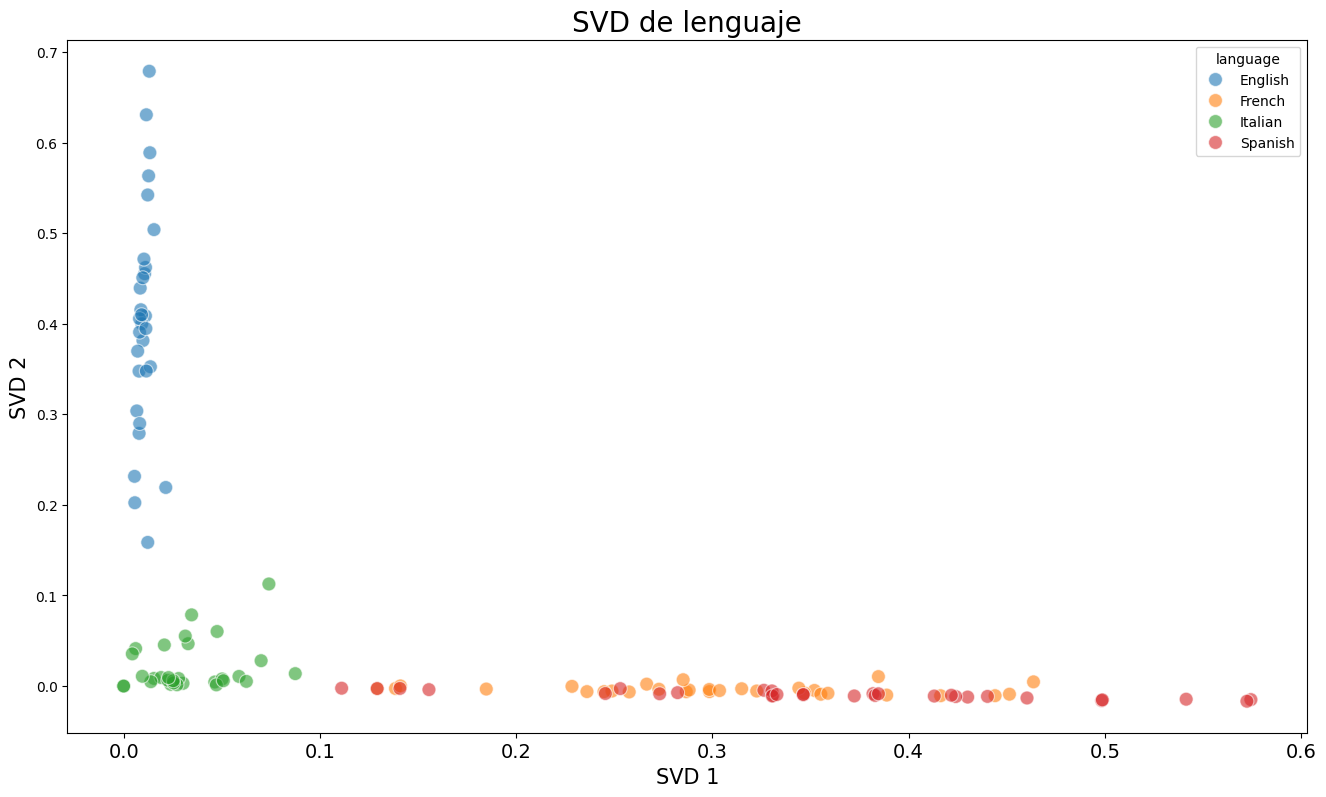

In [120]:
finalDf = pd.concat([principalDf, sample.language], axis = 1)
print(finalDf.head())

#Creamos el plot
plt.figure(figsize = (16, 9))
sns.scatterplot(x = "svd1", y = "svd2", data = finalDf, hue = "language", alpha = 0.6, s = 100);
plt.title('SVD de lenguaje', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("SVD 1", fontsize = 15)
plt.ylabel("SVD 2", fontsize = 15)

-- Interpretacion

In [121]:
#Separmos los datos en prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(df.Text,
                                                    df.code,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    shuffle=True)



X_train_counts = X_CountVectorizer.fit_transform(X_train)
X_train_tfidf = X_TfidfTransformer.fit_transform(X_train_counts)

X_test_counts = X_CountVectorizer.transform(X_test)
X_test_tfidf = X_TfidfTransformer.transform(X_test_counts)



In [122]:
#Primero modelo, Naive Bayes
model = MultinomialNB()

model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

#Evaluación
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       270
           1       1.00      0.96      0.98       184
           2       0.99      0.99      0.99       247
           3       0.96      1.00      0.98       224

    accuracy                           0.98       925
   macro avg       0.98      0.98      0.98       925
weighted avg       0.98      0.98      0.98       925



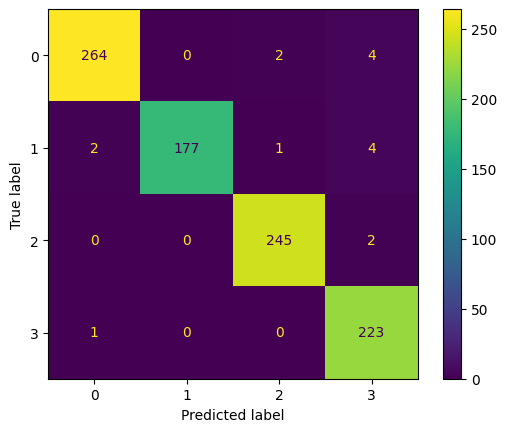

In [123]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

-- Comentar acerca de los resultados

In [124]:
# Implementación del segundo modelo
# Multinomial porque son 21 etiquetas
regr = LogisticRegression(C=5e1, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
regr.fit(X_train_tfidf, y_train)


LogisticRegression(C=50.0, multi_class='multinomial', n_jobs=4, random_state=17)

In [125]:
y_pred = regr.predict(X_test_tfidf)

-- Comentar acerca de los resultados

In [126]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       270
           1       0.99      1.00      0.99       184
           2       1.00      0.99      1.00       247
           3       0.98      1.00      0.99       224

    accuracy                           0.99       925
   macro avg       0.99      0.99      0.99       925
weighted avg       0.99      0.99      0.99       925



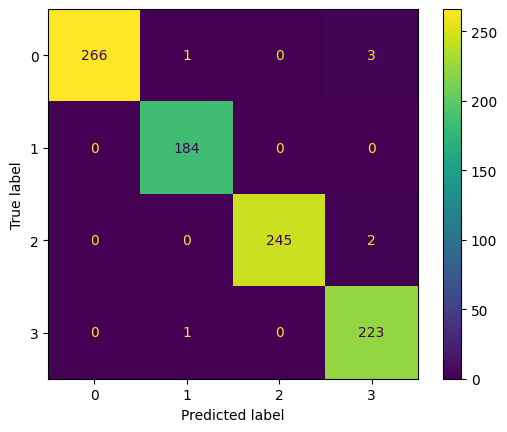

In [127]:
cm = confusion_matrix(y_testL, y_pred, labels=regr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=regr.classes_)
disp.plot()
plt.show()

In [137]:
def predice(texto):

  text = [texto]
  text_counts = X_CountVectorizer.transform(text)
  text_tfidf = X_TfidfTransformer.transform(text_counts)


  prediction1 = model.predict(text_tfidf)
  prediction2 = regr.predict(text_counts)

  print(prediction2)
  print("El modelo Naive bayes dice que es: ", claves[prediction1[0]])
  print("El modelo Logistic Regression dice que es: ", claves[prediction2[0]])


In [138]:


text = "Buenos días, me alegro de que hoy sea un día soleado "
predice(text)



[0]
El modelo Naive bayes dice que es:  Spanish
El modelo Logistic Regression dice que es:  Spanish
